### Import packages and libraries

In [1]:
import os
import glob
import torch
import urllib.request
import cv2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from google.colab import output
output.enable_custom_widget_manager()
from tqdm import tqdm, trange

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


### Reload the best model

In [2]:
# Specify which file would like to retrieve
log_file_path = '/content/gdrive/MyDrive/Colab Notebooks/Training_Log/' + 'CY' + '/epoch_10_2022-08-30 10:38:20.984264.pt'

In [3]:
# Datasets and parameters
img_size = 256

path_test = '/content/gdrive/MyDrive/Colab Notebooks/Final_data/test'

folders = os.listdir(path_test)
folders.sort()
label_dict = dict()
for id, folder in enumerate(folders):
  label_dict[folder] = id

n_class = len(label_dict)


In [4]:
# Model setting
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, n_class)

# Move the model to GPU
device = torch.device("cuda:0")
model = model.to(device)

# Load model
checkpoint = torch.load(log_file_path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Load validation/testing data

In [5]:
class GreenFingerDataset(Dataset):
    def __init__(self, data_path, label_dict, oversample=False, transforms=None):
        # retrieve jpg file path from directory: training/validation/testing
        self.files = sorted(glob.glob(os.path.join(data_path, "*/*.jpg")))
        # convert jpg file path to dataframe and attach true label
        self.df = pd.DataFrame(
            dict(
                cat=[f.split('/')[-2] for f in self.files],
                image_path=self.files
            )
        )
        # copy dataframe
        self.df_oversampled = self.df.copy()
        # process oversample function
        if oversample:
            self.oversample()
        # initialize transform procedure
        self.transforms = transforms
        # initialize true label numbering
        self.label_dict = label_dict

    def oversample(self):
        """
        This functions can be called or 
        initialized automatically when the oversample=True
        """
        # Random sampling til the # of sample matches to the # of largest category
        cats = self.df.cat.drop_duplicates().to_numpy()
        cat_sizes = []

        for c in cats:
            n = len(self.df.query(f"cat == '{c}'"))
            cat_sizes.append(n)

        cat_sizes = np.array(cat_sizes)
        dfs = []
        n_majority = np.max(cat_sizes)

        for i, c in enumerate(cats):
            df_cat = self.df.query(f"cat == '{c}'").sample(frac=n_majority/cat_sizes[i], replace=True)
            dfs.append(df_cat)

        self.df_oversampled = pd.concat(dfs, axis=0).reset_index(drop=True)

    def __len__(self):
        return len(self.df_oversampled)

    def __getitem__(self, idx):
        img_src, cat = self.df_oversampled.iloc[idx][["image_path", "cat"]]
        # What's the difference between torchvision's readimage and PIL's Image.open?
        x = Image.open(img_src)
        # x = read_image(img_src)
        if self.transforms:
            x = self.transforms(x)
        x = x.float()
        if len(x.size()) == 2:
            # when it's multi channels, x.size() shows (Channel, Heigh, Weight)
            # when channel is 1, x.size() shows (Heigh, Weight) w/o channel
            x = x.unsqueeze(0) 
            x = torch.cat((x, x, x), axis=0)
        y = self.label_dict[cat]
        y = torch.Tensor([y]).long()
        
        return x, y

In [6]:
# Transform for Testing Dataset
transforms_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(img_size),
     transforms.CenterCrop(img_size),
     transforms.Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225])])

# Testing Dataset
ds_test = GreenFingerDataset(
    path_test,
    label_dict,
    transforms=transforms_test
)
print("ds_test", len(ds_test))

ds_test 449


### Validation accuracy

In [7]:
model.eval()

batch_size = 128

dl_test = DataLoader(
    ds_test,
    shuffle=False,
    batch_size=batch_size,
    drop_last=False,
)

predictions = []

with torch.no_grad():
    for (x, y) in tqdm(dl_test):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        predictions.append(output.cpu().numpy())
    # Compute Validation Accuracy
    preds_test = np.argmax(np.concatenate(predictions, axis=0), axis=1)
    y_test = np.concatenate([item[1].numpy() for item in ds_test])
    acc_test = np.sum(preds_test == y_test) / len(y_test)
    print(f'Test Acc: {acc_test}')


100%|██████████| 4/4 [05:51<00:00, 87.98s/it]


Test Acc: 0.9755011135857461


### Confusion matrix

Text(104.09375, 0.5, 'true label')

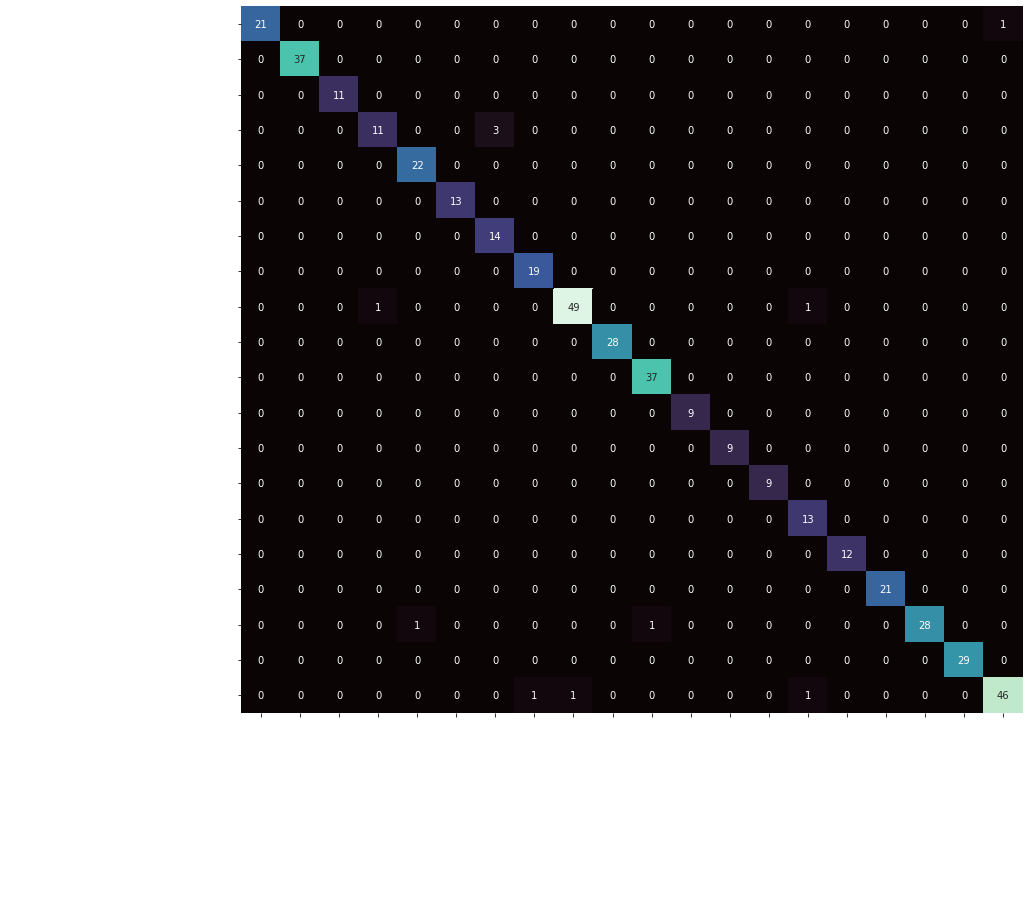

In [8]:
inv_label_dict = {v: k for k, v in label_dict.items()}

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, preds_test)).rename(columns=inv_label_dict, index=inv_label_dict)

confusion_matrix_df = confusion_matrix_df.round(2)

# Plotting
fig, ax = plt.subplots(figsize=(14,13))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, linewidths=0, cbar=False, cmap='mako')

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', color='white', fontsize=15)
plt.setp(ax.get_yticklabels(), color='white', fontsize=15)

plt.xlabel("prediction", fontsize=30, color='white')
plt.ylabel("true label", fontsize=30, color='white')

### Confusion matrix - Recall

Text(104.09375, 0.5, 'true label')

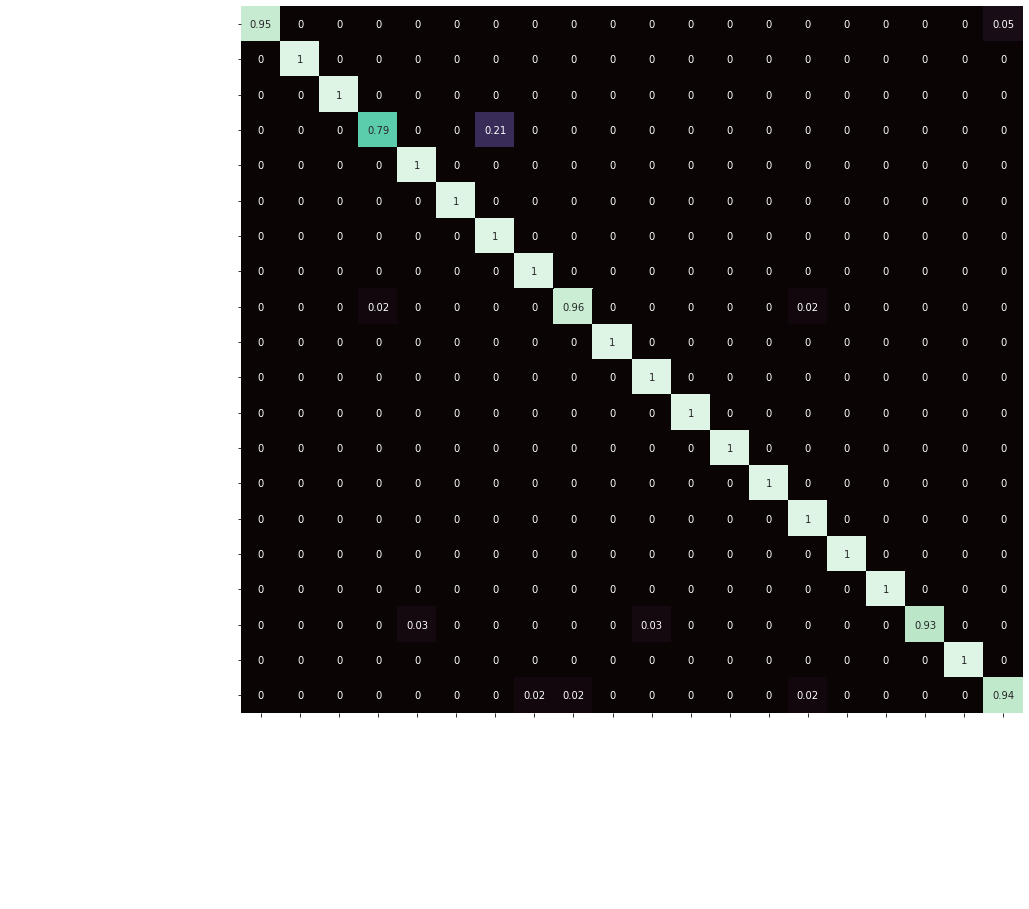

In [9]:
inv_label_dict = {v: k for k, v in label_dict.items()}

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, preds_test, normalize="true")).rename(columns=inv_label_dict, index=inv_label_dict)
# confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, preds_test, normalize="pred")).rename(columns=inv_label_dict, index=inv_label_dict)
# confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, preds_test)).rename(columns=inv_label_dict, index=inv_label_dict)

confusion_matrix_df = confusion_matrix_df.round(2)

# Plotting
fig, ax = plt.subplots(figsize=(14,13))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, linewidths=0, cbar=False, cmap='mako')

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', color='white', fontsize=15)
plt.setp(ax.get_yticklabels(), color='white', fontsize=15)

plt.xlabel("prediction", fontsize=30, color='white')
plt.ylabel("true label", fontsize=30, color='white')

### Confusion matrix - Precision

Text(104.09375, 0.5, 'true label')

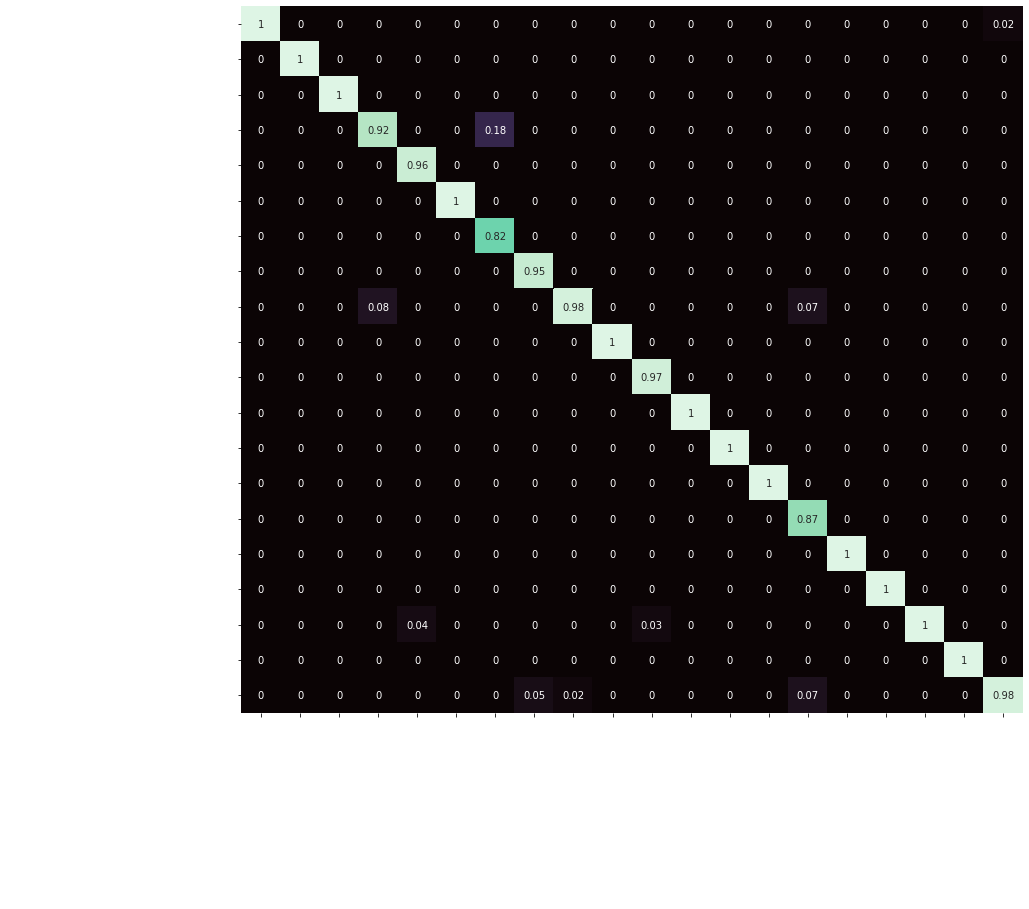

In [10]:
inv_label_dict = {v: k for k, v in label_dict.items()}

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, preds_test, normalize="pred")).rename(columns=inv_label_dict, index=inv_label_dict)

confusion_matrix_df = confusion_matrix_df.round(2)

# Plotting
fig, ax = plt.subplots(figsize=(14,13))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, linewidths=0, cbar=False, cmap='mako')

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', color='white', fontsize=15)
plt.setp(ax.get_yticklabels(), color='white', fontsize=15)

plt.xlabel("prediction", fontsize=30, color='white')
plt.ylabel("true label", fontsize=30, color='white')

#### Confusion matrix: numbers but with normalized color scale

Text(104.09375, 0.5, 'true label')

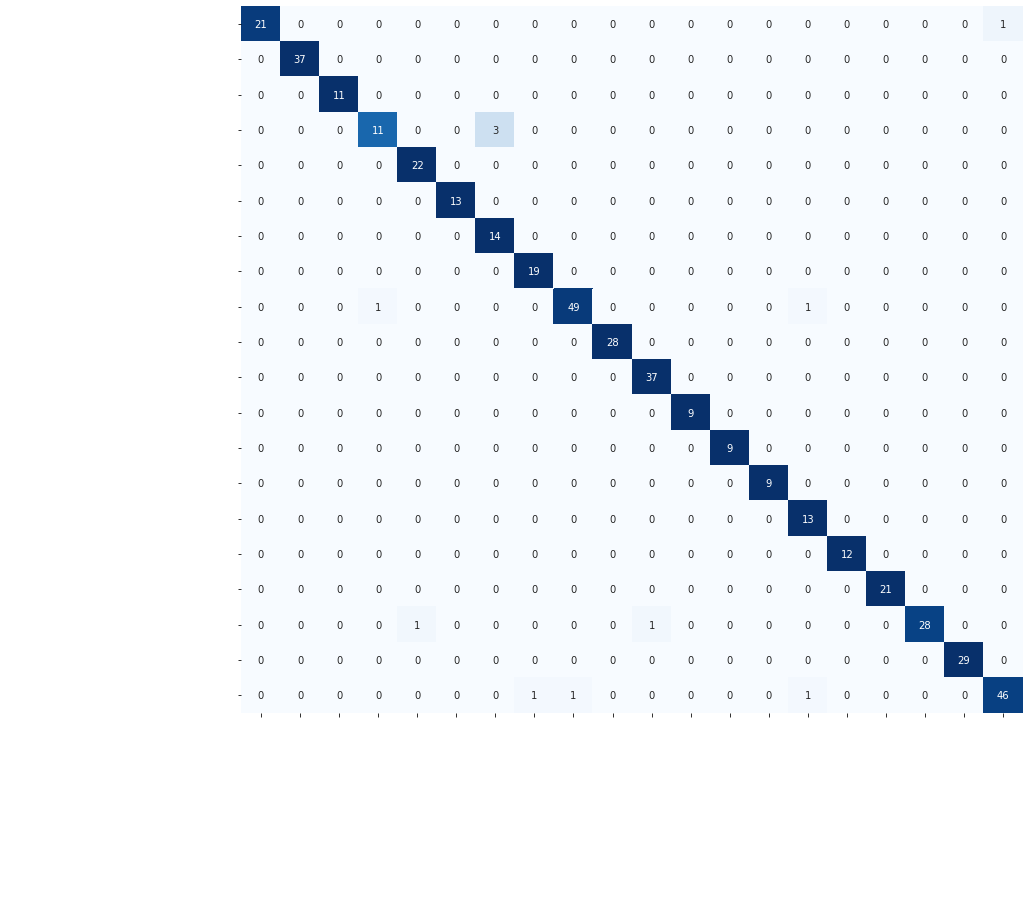

In [24]:
inv_label_dict = {v: k for k, v in label_dict.items()}

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, preds_test, normalize="true")).rename(columns=inv_label_dict, index=inv_label_dict)
# confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, preds_test, normalize="pred")).rename(columns=inv_label_dict, index=inv_label_dict)
# confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, preds_test)).rename(columns=inv_label_dict, index=inv_label_dict)

confusion_matrix_df_numbers = pd.DataFrame(confusion_matrix(y_test, preds_test)).rename(columns=inv_label_dict, index=inv_label_dict)

confusion_matrix_df_numbers = confusion_matrix_df_numbers.round(2)

# print(confusion_matrix_df_numbers)

# Plotting
fig, ax = plt.subplots(figsize=(14,13))         
sns.heatmap(confusion_matrix_df, annot=confusion_matrix_df_numbers, ax=ax, linewidths=0, cbar=False, cmap='Blues')

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', color='white', fontsize=15)
plt.setp(ax.get_yticklabels(), color='white', fontsize=15)

plt.xlabel("prediction", fontsize=30, color='white')
plt.ylabel("true label", fontsize=30, color='white')

In [11]:
plot_f1_dict = sorted(inv_label_dict.items(), reverse=True)
plot_f1_dict

[(19, 'Zamioculcas'),
 (18, 'Tradescantia_zebrina'),
 (17, 'Schefflera_arboricola'),
 (16, 'Rhapis_excelsa'),
 (15, 'Philodendron_gloriosum'),
 (14, 'Peperomia_obtusifolia'),
 (13, 'Peperomia_argyreia'),
 (12, 'Pachira_aquatica'),
 (11, 'Nephrolepis_cordifolia'),
 (10, 'Monstera_deliciosa'),
 (9, 'Maranta_leuconeura'),
 (8, 'Hoya_carnosa'),
 (7, 'Epipremnum_aureum'),
 (6, 'Dypsis_lutescens'),
 (5, 'Dracaena_trifasciata'),
 (4, 'Dracaena_reflexa'),
 (3, 'Chamaedorea_elegans'),
 (2, 'Calathea_orbifolia'),
 (1, 'Asplenium_nidus'),
 (0, 'Aglaonema_commutatum')]

[0.97674419 1.         1.         0.84615385 0.97777778 1.
 0.90322581 0.97435897 0.97029703 1.         0.98666667 1.
 1.         1.         0.92857143 1.         1.         0.96551724
 1.         0.95833333]
0.9754804302474178




Text(0, 0.5, 'Class')

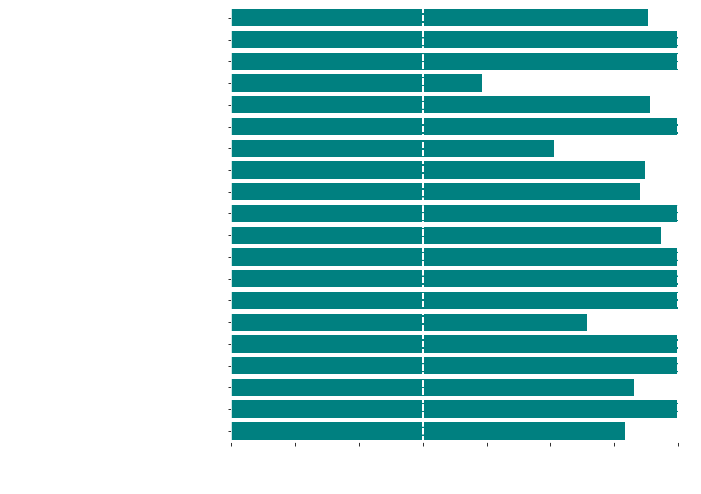

In [12]:
# F1 score
f1 = f1_score(y_test, preds_test, average=None)
print(f1)

w_f1 = f1_score(y_test, preds_test, average='weighted')
print(w_f1)


fig, ax = plt.subplots(figsize=(8,8))         

for i, item in plot_f1_dict:
    ax.barh(item, f1[i], color='teal')

ax.vlines(np.ones(20), -0.5, 20, color='white', ls='--')
ax.vlines(np.ones(20)*0.8, -0.5, 20, color='white', ls='--')

plt.setp(ax.get_xticklabels(), color='white', fontsize=15)
plt.setp(ax.get_yticklabels(), color='white', fontsize=15)

plt.setp(ax.set_xlim(0.65, 1.0))
plt.setp(ax.set_ylim(-0.5 , 19.5))


ax.patch.set_facecolor('none')

for spine in ax.spines.values():
        spine.set_edgecolor('white')

ax.set_xlabel("F1 score", fontsize=20, color='white')
ax.set_ylabel("Class", fontsize=20, color='white')


### Show mis-matched targets

In [13]:
# Initialize transform proceduce for visualizing images

transforms_test_for_viz = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(img_size),
     transforms.CenterCrop(img_size)  # unify all image as square shape
     ])

# Initialize dataset for visualization
ds_test_for_viz = GreenFingerDataset(
    path_test,
    label_dict,
    transforms=transforms_test_for_viz)

print("ds_test_for_viz", len(ds_test_for_viz))

# Filter image's indices where preds != y (unmatched items' indices)
debug_idxs_test = np.where(preds_test != y_test)

# Filter ds_test_for_viz dataframe with unmatched items
debug_df_test = ds_test_for_viz.df.filter(items=debug_idxs_test[0], axis=0)

# Filter preds array with unmatched items
debug_preds_test = preds_test[debug_idxs_test]




ds_test_for_viz 449


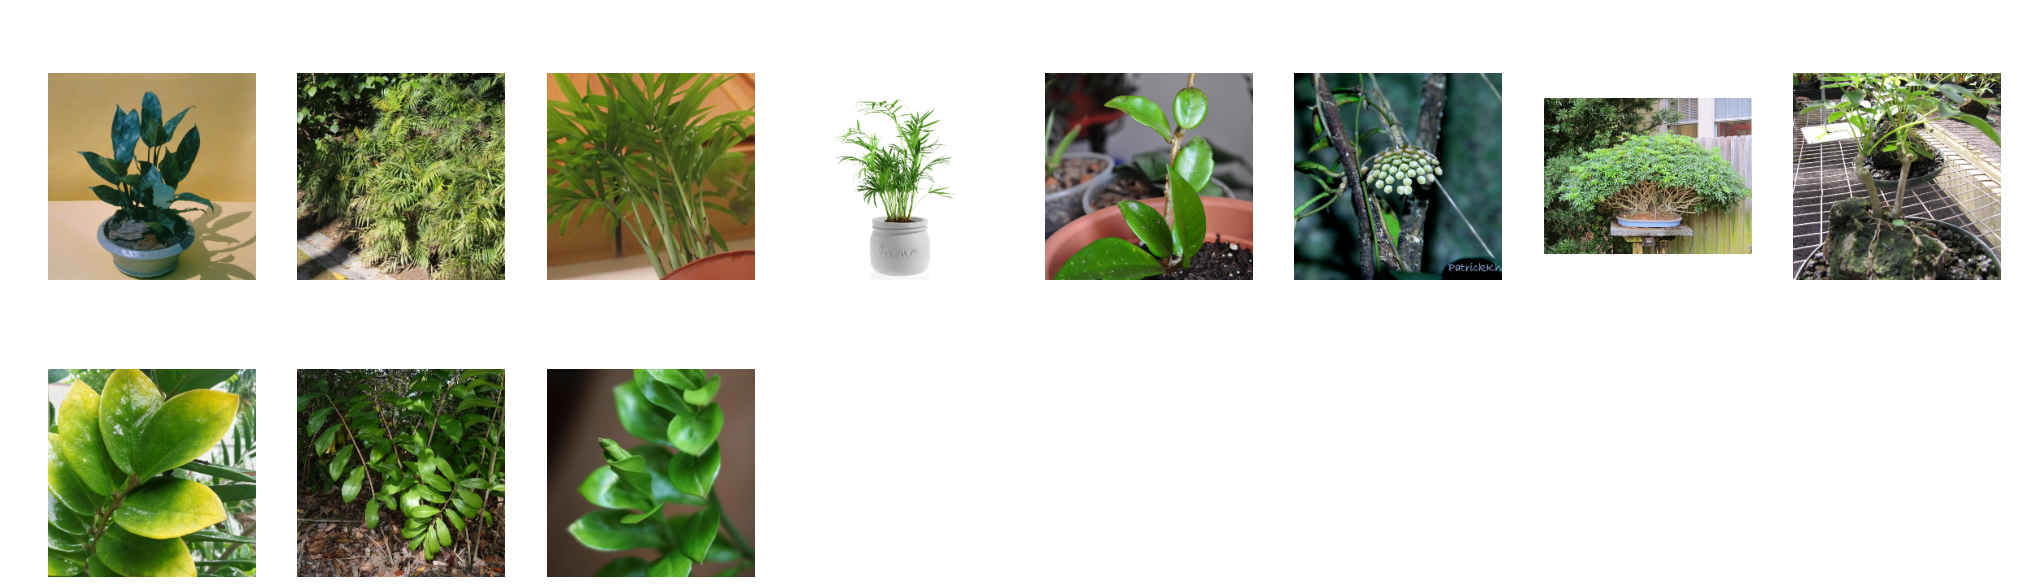

In [14]:
# Visualize wrongly predicted images
fig = plt.figure()
fig.set_size_inches(35, 10)
for i in range(len(debug_df_test)):
    img_src, cat = debug_df_test.iloc[i][["image_path", "cat"]]

    wrong_ind = debug_idxs_test[0][i]
    img, _ = ds_test_for_viz[wrong_ind]
    im = torch.permute(img, [1, 2, 0]).numpy()

    pred = debug_preds_test[i]
    pred = list(label_dict.keys())[list(label_dict.values()).index(pred)]
    plt.subplot(2, 8, i+1)
    plt.imshow(im)
    plt.title(f'T: {cat} \n vs\n P: {pred} ', color='white', fontsize=20)
    plt.axis("off")